In [1]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetB6

In [2]:
# Cell 2: Define constants
BATCH_SIZE = 32
# IMG_HEIGHT = 380 efficientnetv2L
# IMG_WIDTH = 380
# IMG_HEIGHT = 300 #EfficientNetV2B3
# IMG_WIDTH = 300
IMG_HEIGHT = 528 #EfficientNetB6
IMG_WIDTH = 528
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Dataset_alpha"

In [3]:
# Cell 3: Load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.
['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Initiation', 'Left_Click', 'Neutral', 'Nothing', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'Volume_Decrease', 'Volume_Increase']


In [4]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.4),
        layers.RandomWidth(0.2),
        # layers.RandomTranslation(0.2, 0.2),
        layers.RandomCrop(IMG_HEIGHT, IMG_WIDTH)
    ]
)

In [5]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))

In [6]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.3
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


165234480/165234480 [==============================] - 1s 0us/step


In [7]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 528, 528, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 528, 528, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 528, 528, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 528, 528, 3)          0         ['normalization[0][

In [9]:
# Cell 7: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/Dataset_alpha/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)


In [10]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 3.3949 - accuracy: 0.1550

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 390s 8s/step - loss: 3.3949 - accuracy: 0.1550 - val_loss: 2.8867 - val_accuracy: 0.2867
Epoch 2/30
38/38 [==============================] - 173s 5s/step - loss: 2.5276 - accuracy: 0.3150 - val_loss: 2.7549 - val_accuracy: 0.4333
Epoch 3/30
38/38 [==============================] - 174s 5s/step - loss: 2.0021 - accuracy: 0.4725 - val_loss: 2.6102 - val_accuracy: 0.6033
Epoch 4/30
38/38 [==============================] - 173s 5s/step - loss: 1.6331 - accuracy: 0.5933 - val_loss: 2.4330 - val_accuracy: 0.7167
Epoch 5/30
38/38 [==============================] - 174s 5s/step - loss: 1.4591 - accuracy: 0.6517 - val_loss: 2.2778 - val_accuracy: 0.7700
Epoch 6/30
38/38 [==============================] - 174s 5s/step - loss: 1.3433 - accuracy: 0.6933 - val_loss: 2.0524 - val_accuracy: 0.8100
Epoch 7/30
38/38 [==============================] - 173s 5s/step - loss: 1.1678 - accuracy: 0.7458 - val_loss: 1.8452 - val_accuracy: 0.8533
Epoch 8/30
38/38 [======

In [12]:
# Cell 10: Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB6_alpha.h5')

In [ ]:
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Convert one-hot encoded labels back to class labels
    labels = np.argmax(labels.numpy(), axis=1)

    # Append the labels to the lists
    y_true.extend(labels)
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


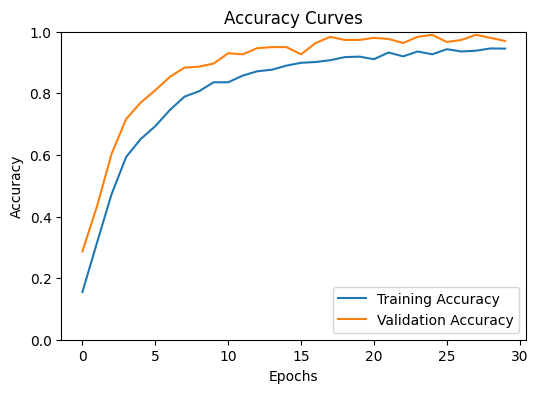

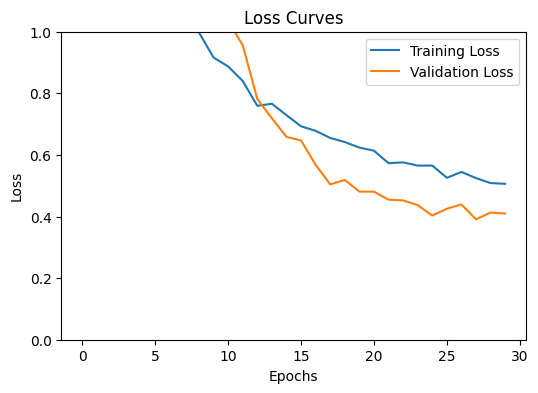

In [13]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [15]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# we chose to train the top 2 blocks, i.e. we will freeze
# the first 668 layers and unfreeze the rest:
for layer in model.layers[:668]:
   layer.trainable = False
for layer in model.layers[668:]:
   layer.trainable = True
# we need to recompile the model for these modifications to take effect
# we train our model again (this time fine-tuning the top 2 blocks
# alongside the top Dense layers
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 3
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/3
38/38 [==============================] - 198s 5s/step - loss: 0.5011 - accuracy: 0.9475 - val_loss: 0.4084 - val_accuracy: 0.9833
Epoch 2/3
38/38 [==============================] - 173s 4s/step - loss: 0.5065 - accuracy: 0.9483 - val_loss: 0.4025 - val_accuracy: 0.9800
Epoch 3/3
38/38 [==============================] - 175s 5s/step - loss: 0.5149 - accuracy: 0.9400 - val_loss: 0.3896 - val_accuracy: 0.9833


In [16]:
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Convert one-hot encoded labels back to class labels
    labels = np.argmax(labels.numpy(), axis=1)

    # Append the labels to the lists
    y_true.extend(labels)
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 5s 5s/step


Accuracy: 0.9866666666666667
Precision: 0.987721939895853
Recall: 0.9898284313725491
F1 Score: 0.9883359070434938
AUC-ROC: 0.9944375893724325


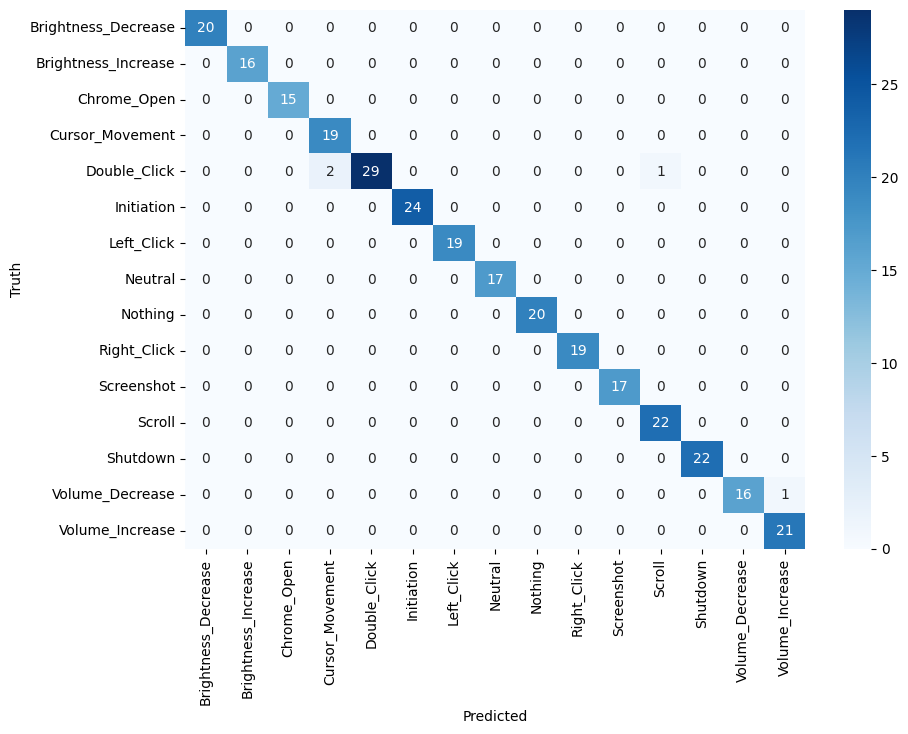

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on your problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
class_names = ["Brightness_Decrease", "Brightness_Increase", "Chrome_Open", "Cursor_Movement", "Double_Click", "Initiation", "Left_Click", "Neutral", "Nothing", "Right_Click", "Screenshot", "Scroll", "Shutdown", "Volume_Decrease", "Volume_Increase"]

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [19]:
# Cell 10: Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetV2B3_fine_tuned.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


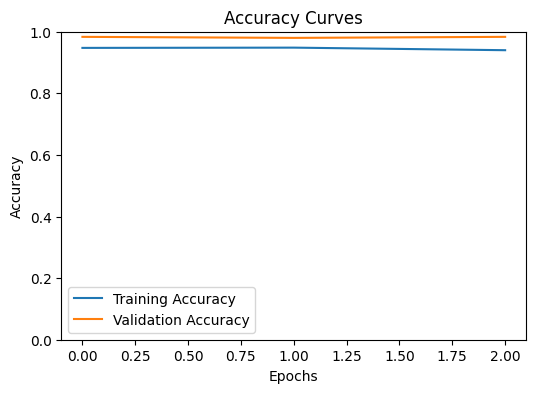

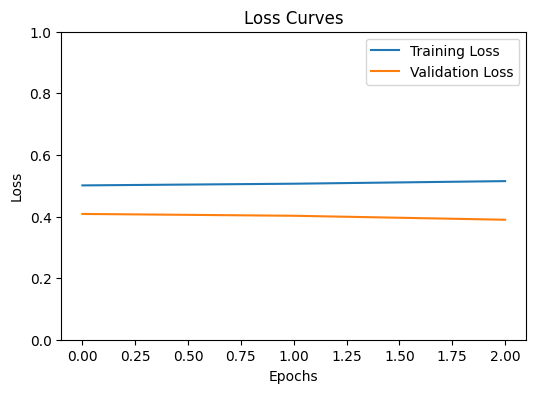

In [20]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
